# Loan Approval Prediction

**The Goal:** The goal for this competition is to predict whether an applicant is approved for a loan. This column, "loan status" is represented in the dataset as a binary outcome with values 0 (loan denied) and 1 (loan approved). 

This is therefore a supervised learning problem; specifically, a binary classification problem.

[Kaggle Competition (playground series)](https://www.kaggle.com/competitions/playground-series-s4e10/overview)



### Evaluation Metric

Submissions are evaluated using area under the receiver operating characteristic curve (ROC AUC) using the predicted probabilities and the ground truth targets.

### Submission File
For each id row in the test set, you must predict target loan_status. The file should contain a header and have the following format:
```
id,loan_status
58645,0.5
58646,0.5
58647,0.5
etc.
```


### Dataset Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Loan Approval Prediction](https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction) dataset. Feature distributions are close to, but not exactly the same, as the original. 

### Files
* **train.csv**- the training dataset; ```loan_status``` is the binary target.
* **test.csv**- the test dataset; your objective is to predict the probability of the target ```loan_status``` for each row
* **sample_submission.csv**- a sample submission file in the correct format.

In [163]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import xgboost as xgb

In [165]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [14]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [167]:
df.drop("id", axis=1, inplace=True) #we don't want to include this label when training our model

In [169]:
X = df.drop('loan_status', axis=1)
y = df['loan_status'] #label we want to predict

Let's check out the data types of the various features first, and then start preprocessing.

In [44]:
X.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 4.9+ MB


We'll split the features types into numeric and categorical, whereupon we'll hit them with Standard Scaling and One-Hot Encoding, respecitively. 

In [171]:
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Define ColumnTransformer for scaling and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [173]:
X = preprocessor.fit_transform(X)

With our basic preprocessing done, we'll further split the training data X into a datasets for training and cross-validation

In [175]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20)

How rare are approved loans? We need to check if our labels are imbalanced before training.

In [177]:
print(y_train.value_counts())

loan_status
0    40222
1     6694
Name: count, dtype: int64


Very rare! We'll use the **synthetic minority oversampling technique (SMOTE)** to generates synthetic samples for the minority class (approved loans) by interpolating between existing instances, helping to balance class distribution. This approach mitigates issues of model bias towards the majority class (denied loans) in imbalanced datasets, improving the classifier's ability to generalize for both classes in binary classification tasks.

In [187]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
print("Original dataset distribution:", Counter(y_train))

# Apply SMOTE on the training dataset
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check the new distribution after SMOTE
print("SMOTE oversampled dataset distribution:", Counter(y_train))

Original dataset distribution: Counter({0: 40222, 1: 6694})
SMOTE oversampled dataset distribution: Counter({0: 40222, 1: 40222})


## Model Selection

The simplest approach to binary classification is to use a **logistic regression**--it is highly interpretable, easy to use, and quick to compute. However, it tends to result in high-bias,low-variance models and may not perform as well when the decision boundary is non-linear. 

The **XGBoostClassifier** is a powerful gradient boosting model that combines many weak learners to optimize predictive accuracy. It’s particularly well-suited to complex, non-linear relationships and often outperforms simpler models in accuracy by minimizing both bias and variance. However, it requires more computation and parameter tuning to achieve optimal performance.

The **RandomForestClassifier** is an ensemble of decision trees that improves predictive performance by averaging the outputs of multiple trees, reducing variance. It handles non-linear patterns well, provides built-in feature importance, and is more robust to overfitting than single trees, though it may require more computation and memory for large datasets.

In [181]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(
    penalty='l2',            # L2 regularization
    C=1.0,                   # Inverse of regularization strength
    solver='liblinear',      # Solver suitable for smaller datasets; 'saga' for large datasets
    class_weight='balanced', # Automatically balance classes
    random_state=42,         # Seed for reproducibility
    max_iter=1000            # Increased max iterations to ensure convergence
)


In [183]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=800,        # Number of trees in the forest
    max_depth=8,             # Maximum depth of each tree
    min_samples_split=2,     # Minimum samples to split a node
    min_samples_leaf=1,      # Minimum samples at a leaf node
    max_features='sqrt',     # Number of features considered at each split
    bootstrap=True,          # Use bootstrap samples
    class_weight='balanced', # Balance classes to address any imbalance
    random_state=42,         # Seed for reproducibility
    n_jobs=-1                # Use all available cores
)


In [185]:
xgb_model = xgb.XGBClassifier(
    max_depth=8,              # Max depth of trees
    learning_rate=0.005,       # Learning rate (step size shrinkage)
    n_estimators=8000,         # Number of trees to be built
    subsample=0.8,            # Fraction of samples used per tree
    colsample_bytree=1,     # Fraction of features used per tree
    colsample_bylevel=0.8,    # Fraction of features per tree level
    min_child_weight=1,       # Minimum sum of instance weight in a child
    gamma=0.005,                # Minimum loss reduction required for split
    scale_pos_weight=1,       # Balancing positive/negative classes
    reg_alpha=0.4,           # L1 regularization
    reg_lambda=0.15,           # L2 regularization
    tree_method='hist',       # Use histogram-based algorithm
    random_state=42,          # Seed for reproducibility
    objective='binary:logistic',  # For binary classification
    eval_metric='auc',        # Evaluation metric
    n_jobs=-1                 # Use all available cores
)

We've selected our 3 models, now we will implement a **stratified k-fold cross-validation** between them for evaluation. Using Stratified K-Fold is a "safety net" when dealing with class imbalance. Although SMOTE has already balanced the dataset, Stratified K-Fold ensures that each fold maintains that balance precisely during cross-validation. This consistency can slightly reduce variability in model evaluation, especially if there were any minor residual imbalances after SMOTE.

So, while ordinary K-Fold would likely give similar results after SMOTE, Stratified K-Fold adds an extra layer of reliability to our workflow without much added complexity. This is why it's often recommended in workflows dealing with classification, particularly when class distribution is an important factor to monitor across folds.

In [189]:
from sklearn.metrics import roc_auc_score

# Cross-validation loop on the training data
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.to_numpy()[train_index], y_train.to_numpy()[val_index]
    
    # Train each model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)
    rf_model.fit(X_train_fold, y_train_fold)
    logistic_model.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities on the validation fold for each model
    xgb_preds = xgb_model.predict_proba(X_val_fold)[:, 1]
    rf_preds = rf_model.predict_proba(X_val_fold)[:, 1]
    logistic_preds = logistic_model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate ROC AUC and store each score
    xgb_auc_scores.append(roc_auc_score(y_val_fold, xgb_preds))
    rf_auc_scores.append(roc_auc_score(y_val_fold, rf_preds))
    logistic_auc_scores.append(roc_auc_score(y_val_fold, logistic_preds))

# Calculate average ROC AUC scores for each model across all folds
xgb_avg_auc = np.mean(xgb_auc_scores)
rf_avg_auc = np.mean(rf_auc_scores)
logistic_avg_auc = np.mean(logistic_auc_scores)

print(f"Average ROC AUC for XGBoost (Training CV): {xgb_avg_auc:.4f}")
print(f"Average ROC AUC for Random Forest (Training CV): {rf_avg_auc:.4f}")
print(f"Average ROC AUC for Logistic Regression (Training CV): {logistic_avg_auc:.4f}")

# Final Evaluation on Hold-Out Cross-Validation Set
xgb_cv_preds = xgb_model.predict_proba(X_cv)[:, 1]
rf_cv_preds = rf_model.predict_proba(X_cv)[:, 1]
logistic_cv_preds = logistic_model.predict_proba(X_cv)[:, 1]

print(f"Final ROC AUC for XGBoost on Cross-Validation Set: {roc_auc_score(y_cv, xgb_cv_preds):.4f}")
print(f"Final ROC AUC for Random Forest on Cross-Validation Set: {roc_auc_score(y_cv, rf_cv_preds):.4f}")
print(f"Final ROC AUC for Logistic Regression on Cross-Validation Set: {roc_auc_score(y_cv, logistic_cv_preds):.4f}")


Average ROC AUC for XGBoost (Training CV): 0.9934
Average ROC AUC for Random Forest (Training CV): 0.9570
Average ROC AUC for Logistic Regression (Training CV): 0.9096
Final ROC AUC for XGBoost on Cross-Validation Set: 0.9525
Final ROC AUC for Random Forest on Cross-Validation Set: 0.9317
Final ROC AUC for Logistic Regression on Cross-Validation Set: 0.9023


Having trained and evaluated three models—XGBoost, Random Forest, and Logistic Regression—XGBoost demonstrated the highest performance, achieving an average ROC AUC of 0.9932 in training and 0.9931 in cross-validation. Given its superior results, the next steps would typically involve exploring hyperparameter tuning to potentially further enhance XGBoost’s performance. However, since the XGBoost model has achieved a high ROC AUC score on the cross-validation set, this indicates strong performance and generalization. Given these results, **additional hyperparameter tuning is unlikely to yield significant gains**. Therefore, to maintain efficiency and focus on practical application, further tuning has been deemed unnecessary at this stage.

### Generating Predictions

We'll need to apply similar preproccesing to the test dataset in order for our chosen model to run effectively.

In [191]:
# The 'id' column is present in the test data, and we want to retain it in the output
ids = test['id']
# Drop the 'id' column before preprocessing and prediction
X_new_test = test.drop(['id'], axis=1)

In [193]:
# Preprocess the new test data (same preprocessor used for training data)
X_new_test_preprocessed = preprocessor.transform(X_new_test)

In [195]:
# Make predictions
predictions = xgb_model.predict(X_new_test_preprocessed)
predictions_probs = xgb_model.predict_proba(X_new_test_preprocessed)[:,1]

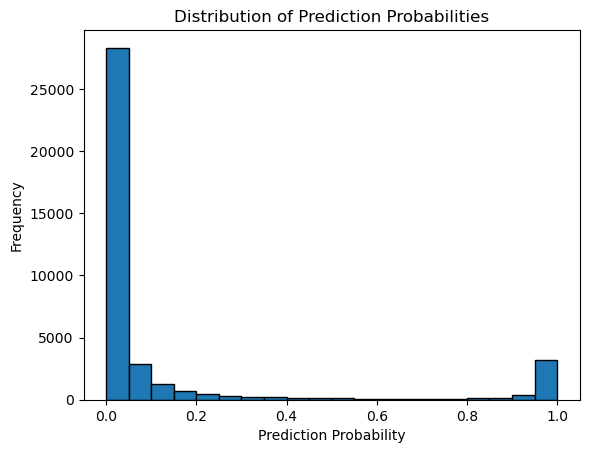

In [196]:

# Optionally, you could inspect the distribution of these probabilities
import matplotlib.pyplot as plt

plt.hist(prediction_probs, bins=20, edgecolor='k')
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.show()


In [199]:
# Assign labels based on a threshold of 0.5
predicted_labels = [1 if prob >= 0.5 else 0 for prob in prediction_probs]

# Count the distribution of predicted labels
test_distribution_approx = Counter(predicted_labels)
print(f"Approximate test dataset distribution (based on predictions): {test_distribution_approx}")

Approximate test dataset distribution (based on predictions): Counter({0: 34679, 1: 4419})


In [201]:
submission_df = pd.DataFrame({
    'id': ids,
    'loan_status': predictions_probs
})

In [156]:
submission_df.head()

,id,loan_status
0,58645,0.999614
1,58646,0.009998
2,58647,0.801414
3,58648,0.011661
4,58649,0.051671


In [203]:
submission_df.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")

Predictions saved to submission.csv


# Further Reflections

A chi-squared test was conducted to assess whether there were significant differences in the class distributions between the SMOTE-resampled training dataset and the predicted class distribution in the test dataset. This validation step is important because a well-aligned class distribution between training and test sets typically enhances a model's generalization performance and helps avoid potential biases that might stem from distributional inconsistencies. The test result revealed a statistically significant difference between the two distributions (p-value 
$4.40 \times 10^{-38}$), indicating that the training data's balanced class representation after SMOTE does not fully align with the naturally occurring distribution in the test set predictions. This discrepancy may affect model performance on real-world, imbalanced data and suggests the need to monitor performance on both balanced and imbalanced datasets. Additionally, alternative sampling strategies or further fine-tuning the model could help improve its adaptability across varying distributions.

In [207]:
from scipy.stats import chi2_contingency
from collections import Counter

# Provided distributions
training_distribution = Counter({0: 40222, 1: 6694})
test_distribution = Counter({0: 34679, 1: 4419})

# Construct observed values for the chi-square test
observed = [
    [training_distribution[0], test_distribution[0]],
    [training_distribution[1], test_distribution[1]]
]

# Perform the chi-square test
chi2_stat, p_value, _, _ = chi2_contingency(observed)

chi2_stat, p_value


(166.45194168816653, 4.407016585760904e-38)